In [1]:
import string

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv('data/904_cleaned_data.csv', index_col=0)

In [3]:
df.describe()

,Could you tell where you are located?,floor,ground-floor,emotion,comfort
count,112,111,112,107,103
unique,4,4,5,102,103
top,A,1st Floor,Group work tables,Relaxed,I feel comfortable but watched
freq,57,62,39,4,1


In [4]:
df = df.rename(columns={"Could you tell where you are located?": "building", "ground-floor": "space-type"})

In [5]:
df

,building,floor,space-type,emotion,comfort
1,C,Ground floor,Group work tables,Chill,I feel comfortable but watched
2,C,Ground floor,Meeting/communal space,"Relaxed, friendly,",NaN
3,A,Ground floor,Meeting/communal space,Relaxed,7/10
4,A,Ground floor,Cafe,Sad,Neutral
5,C,Ground floor,Meeting/communal space,Feels good to see people having fun (for examp...,"The presence of sunlight gives a comfortable, ..."
...,...,...,...,...,...
113,Unsure,1st Floor,Quiet study space,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN
115,A,Ground floor,Cafe,I feel comfortably,NaN
116,NaN,NaN,NaN,NaN,NaN


# Responses Across the Building 904

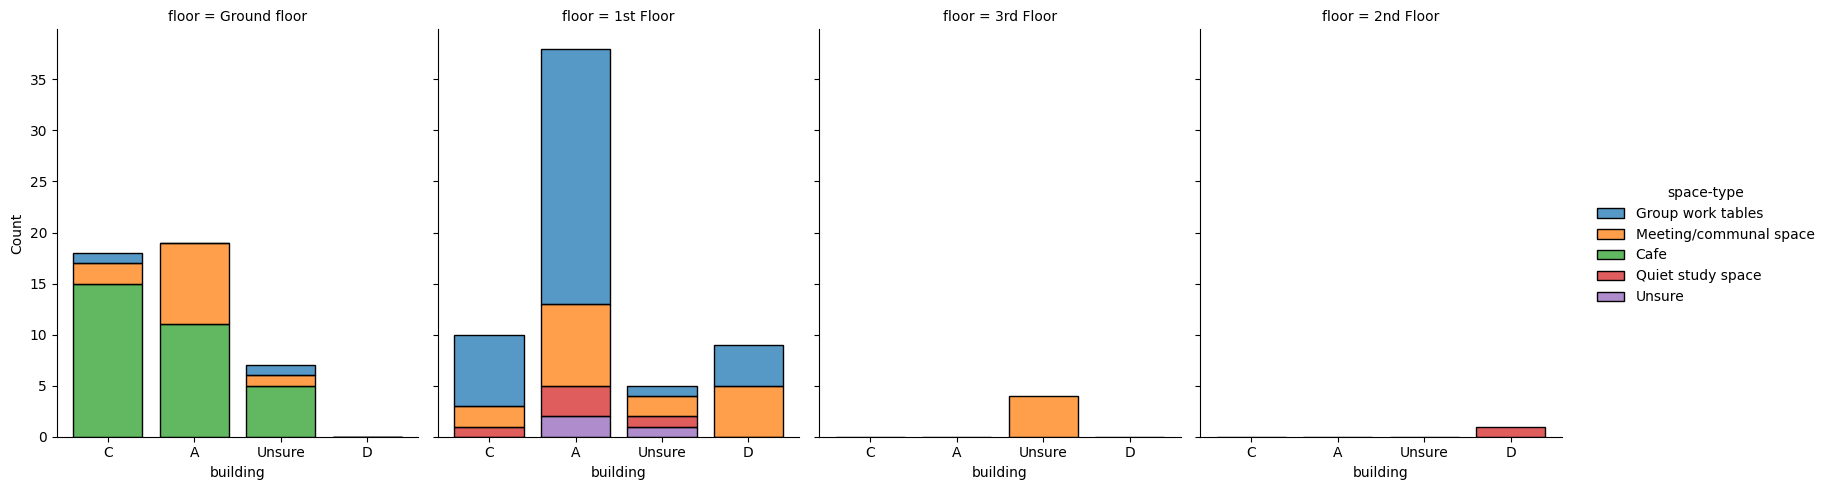

In [6]:
# fig, ax = plt.subplots()
sns.displot(df, x="building",
            hue="space-type",
            col="floor",
            multiple="stack",
            height=5,
            aspect=0.8,
            shrink=.8)
# fig.set_size_inches(8, 5)
plt.savefig('plots/904-floors-responses.jpg', dpi=300, bbox_inches="tight")

# Students Across the Floors

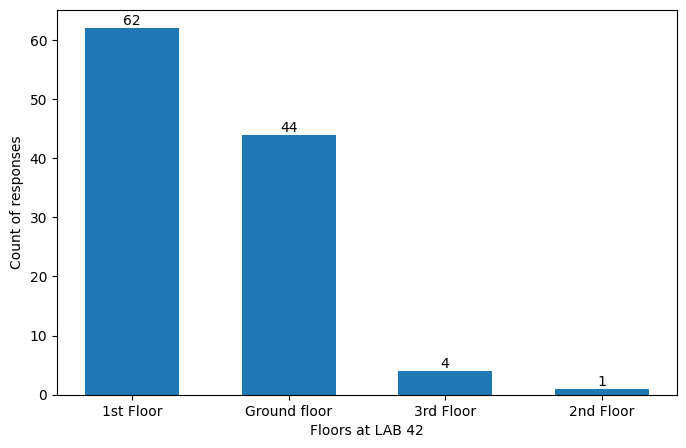

In [7]:
fig, ax = plt.subplots()
data = df.floor.value_counts()
data = pd.DataFrame(data).reset_index().rename(columns={"index": "Floor", "floor": "Count of Responses"})
width = 0.6

p=ax.bar(data.Floor, data["Count of Responses"], width)
ax.bar_label(p, label_type='edge')
plt.ylabel("Count of responses")
plt.xlabel("Floors at LAB 42")
fig.set_size_inches(8, 5)
plt.savefig('plots/floors-responses.jpg', dpi=300, bbox_inches="tight")

# Emotions

In [8]:
df_emo = df.emotion.dropna()
df_emo = df_emo.apply(lambda x: x.replace('’', ''))

### Tokenise

In [9]:
import string

def apply_token(row):
    stop_words = set(stopwords.words("english"))
    words_in_sent = word_tokenize(row)

    filtered_list = []
    
    for word in words_in_sent:
        if word.casefold() not in stop_words:
            filtered_list.append(word)
    
    return filtered_list


def cleanup(df_emo):
    combo_emo = []
    for row in df_emo:
        combo_emo.append(row)
    
    combo_emo = list(np.concatenate(combo_emo).flat)
    combo_emo = list(filter(lambda token: token not in string.punctuation,
                            combo_emo))
    combo_emo = [x.lower() for x in combo_emo]
    
    return combo_emo

In [10]:
df_emo = df_emo.apply(apply_token)
combo_emo_list = cleanup(df_emo)

In [16]:
def frequency_distribution(lst, label):
    top_n = FreqDist(lst).most_common(20)
    frequency_distribution = pd.Series(dict(top_n))

    sns.set_theme(style="ticks")
    sns.barplot(y=frequency_distribution.index,
                x=frequency_distribution.values,
                palette = 'hls',
                saturation = 8)
    plt.xlabel("Count of responses")
    plt.ylabel("Most frequently occuring responses")
    plt.gcf().set_size_inches(5,7)
    # plt.xlim(0,20)

    plt.savefig('plots/904-' + label + '-freq-dist.jpg',
            dpi=300, bbox_inches='tight')

In [14]:
frequency_distribution = FreqDist(combo_emo_list)
frequency_distribution.most_common(20)

[('relaxed', 22),
 ('happy', 13),
 ('good', 11),
 ('bit', 11),
 ('calm', 10),
 ('stressed', 10),
 ('work', 9),
 ('feel', 9),
 ('fine', 8),
 ('feeling', 8),
 ('comfortable', 7),
 ('open', 7),
 ('space', 7),
 ('people', 6),
 ('nice', 6),
 ('tired', 6),
 ('distracted', 6),
 ('okay', 5),
 ('also', 5),
 ('little', 5)]

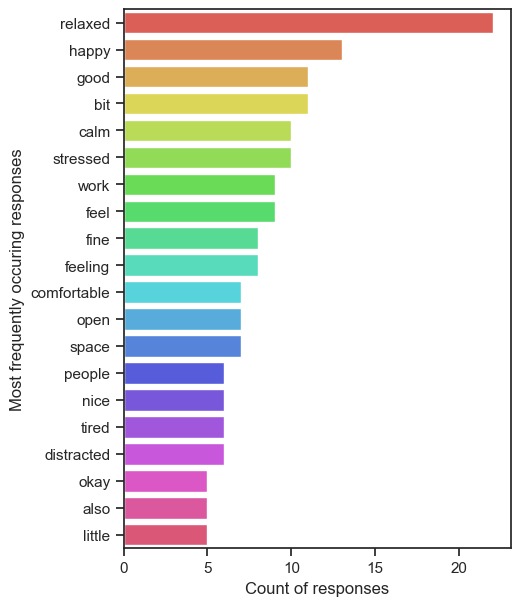

In [17]:
frequency_distribution(combo_emo_list, 'emo')

### Lemmatisation

In [18]:
def lemmatiser(labels):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in labels]
    return lemmatized_words

def check_collocations(lst):
    return nltk.Text(lst).collocations()
    
def find_collocations(df_emo):
    lem_emo = df_emo.apply(lemmatiser)
    combined_emos = list(np.concatenate(lem_emo.to_list()).flat)
    return check_collocations(combined_emos)

In [19]:
find_collocations(df_emo)

Little cold; Slightly stressed; study space; Good vibe; place work;
bit tired; Relaxed Relaxed


# Comfort

In [30]:
df_comfort = df.comfort.dropna()
df_comfort = df_comfort.apply(lambda x: x.replace('’', ''))

### Tokenise

In [31]:
df_comfort = df_comfort.apply(apply_token)
combo_comfort_list = cleanup(df_comfort)
combo_comfort_list = [word for word in combo_comfort_list if word != "'s"]

In [32]:
frequency_distribution = FreqDist(combo_comfort_list)
frequency_distribution.most_common(20)

[('comfortable', 46),
 ('noise', 35),
 ('bit', 26),
 ('light', 25),
 ('good', 24),
 ('temperature', 23),
 ('quite', 17),
 ('air', 17),
 ('feel', 16),
 ('nice', 15),
 ('cold', 15),
 ('fine', 14),
 ('quality', 13),
 ('noisy', 12),
 ('lot', 12),
 ('little', 9),
 ('chairs', 9),
 ('pretty', 9),
 ('like', 8),
 ('loud', 7)]

In [33]:
frequency_distribution(combo_comfort_list, 'comfort')

TypeError: 'FreqDist' object is not callable

'comfortable' (23), 'light'(12), 'cold' (10), 'good' (10), 'noise' (9), 'temperature' (8), 'air' (8), 'nice' (8), 'room' (7), ('pretty', 7), ('space', 5), ('quality', 5), ('window', 5), ('fine', 5), ('like', 5), ('noisy', 5), ('little', 5), ('well', 4), ('lighting', 4), ('warm', 4), ('lot', 4), ('make', 4), ('feel', 4), ('blinds', 4), ('dark', 4), ('natural', 4), ('ok', 4), ('perfect', 3)

Most focus on light and temperature followed by noise. People also noted overall space and comfort as a whole. 

### Lemmatisation

In [ ]:
find_collocations(df_comfort)

Air quality was the most ferquently occuring word.

In [ ]:
from collections import Counter
combo_comfort_cloud=Counter(combo_comfort_list)

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate_from_frequencies(combo_comfort_cloud)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

# Sentiment Analysis

In [34]:
def sentiment_analysis(df, label):
    analyzer = SentimentIntensityAnalyzer()
    df[label + '-polarity'] = df[label].apply(lambda x: analyzer.polarity_scores(str(x)))
    df = pd.concat([df, df[label + '-polarity'].apply(pd.Series)], axis=1)
    df[label + '-sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

    print("Most positive emotion statement: ", df.loc[df['compound'].idxmax()].values)
    print("\n")
    print("Most negative emotion statement: ", df.loc[df['compound'].idxmin()].values)
    
    return df 


def plot_sentiment_analysis(df, label):
    sns.countplot(y=label+'-sentiment', 
                  data=df,
                  palette=['#b2d8d8',"#008080", '#db3d13'],
                  order=["positive", "negative", "neutral"])
    plt.ylabel("Sentiment for " + label + " Text")
    plt.xlabel("Count")
    # plt.xlim(0,45)
    plt.savefig('plots/904-' + label + '-sentiment-count.jpg',
                dpi=300, bbox_inches='tight')
    
    plt.clf()
    
    sns.boxplot(x='floor', y='compound', data=df)
    plt.xlabel("Floor")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/904-' + label + '-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')
    
    
    
def plot_sentiment_analysis_spaces(df, label):
    df['space-type'] = df['space-type'].replace("Group work tables", "group")
    df['space-type'] = df['space-type'].replace("Cafe", "group")
    df['space-type'] = df['space-type'].replace("Meeting/communal space", "individual")
    df['space-type'] = df['space-type'].replace("Quiet study space", "individual")
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='compound', width=0.5,
 data=df)
    plt.xlabel("Floor")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/904-' + label + '-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')

Most positive emotion statement:  ['A' '1st Floor' 'individual'
 "I am enjoying the sunlight shining in through the windows of the cafeteria. This makes me happy. I feel focused because this is a relatively quiet working area, also I don't feel unconfortable because it's not too quiet."
 'I enjoy the temperature and air quality. I feel good in the natural sunlight. The noise level is good for focusing.'
 {'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'compound': 0.8658} 0.0 0.762
 0.238 0.8658 'positive']


Most negative emotion statement:  ['C' '1st Floor' 'group' 'stressed, bored'
 'temperature okay, noise okay (although cafeteria is a little bit noisy), air quality fine'
 {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423} 1.0 0.0 0.0
 -0.5423 'negative']


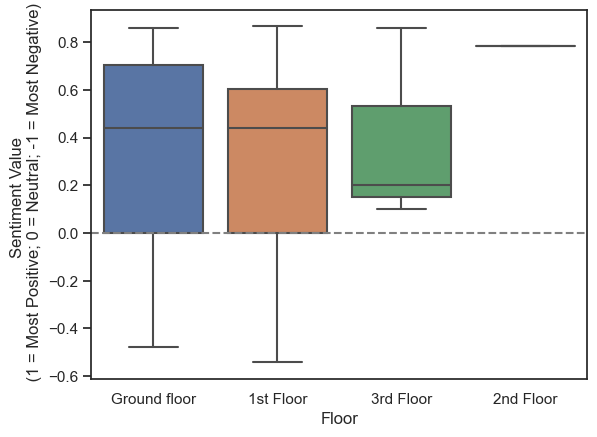

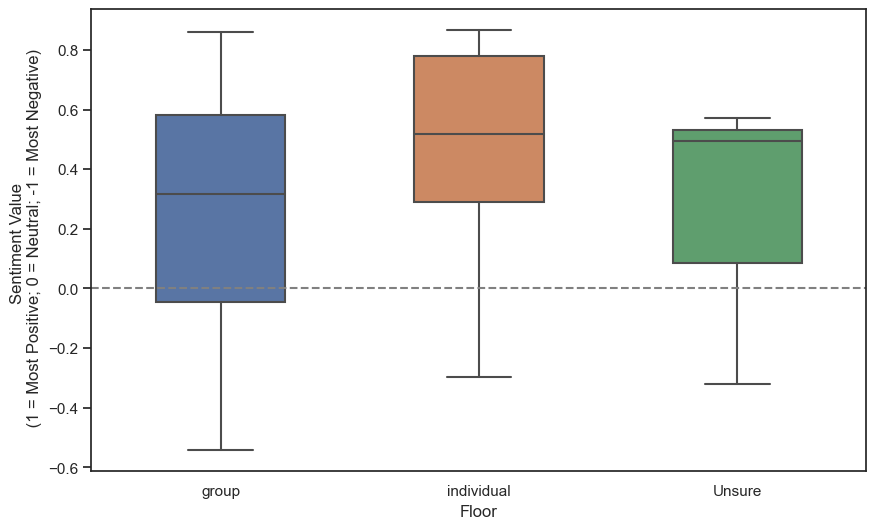

In [28]:
df = df.dropna(subset=['emotion'], how='all')
df_sent_emo = sentiment_analysis(df, 'emotion')
plot_sentiment_analysis(df_sent_emo, 'emotion')
plot_sentiment_analysis_spaces(df_sent_emo, "emotion")

### Emotion: `relaxed`

In [ ]:
df_sent_emo[['floor','emotion', 'emotion-sentiment']][df_sent_emo['emotion'].str.contains("relaxed")==True]

In [ ]:
for row in df_sent_emo['emotion'][df_sent_emo['emotion'].str.contains("calm")==True]:
    print(row)

## Comfort:

Most positive emotion statement:  ['A' '1st Floor' 'group' 'concentrated'
 "pretty comfortabel, but the seats could use some pillows, square tables would be best. it is very light in the space, which is nice, but it also reminds me a bit of a hospital, not very 'gezellig'. temperature is also good; not too hot and not too cold, nice study temperature. "
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
 {'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'compound': 0.9645} 0.0 0.697
 0.303 0.9645 'positive']


Most negative emotion statement:  ['D' '1st Floor' 'individual' 'Relaxed' 'I’m mad I the milk is empty'
 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4939}
 {'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.6124} 0.556 0.444
 0.0 -0.6124 'negative']


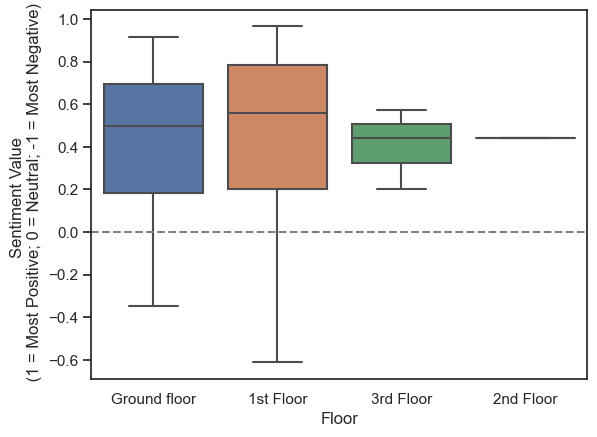

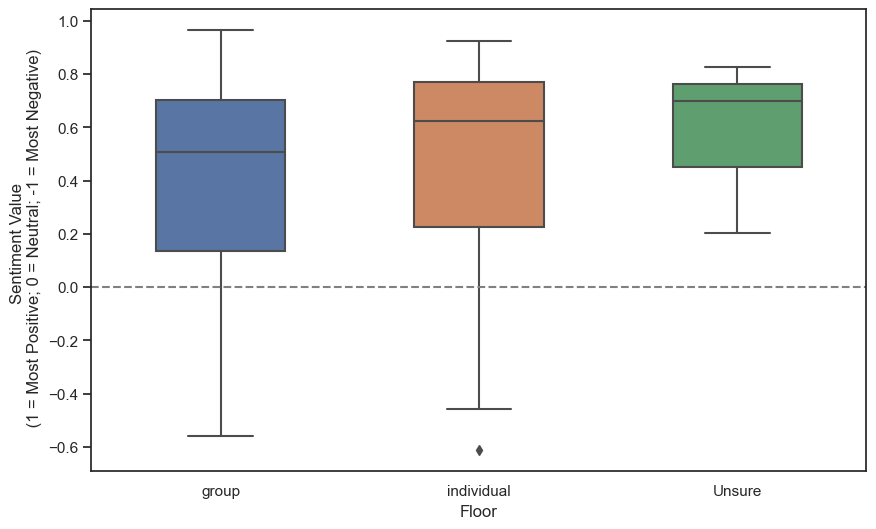

In [36]:
df = df.dropna(subset=['comfort'], how='all')
df_sent_comfort = sentiment_analysis(df, 'comfort')
plot_sentiment_analysis(df_sent_comfort, 'comfort')
plot_sentiment_analysis_spaces(df_sent_comfort, "comfort")